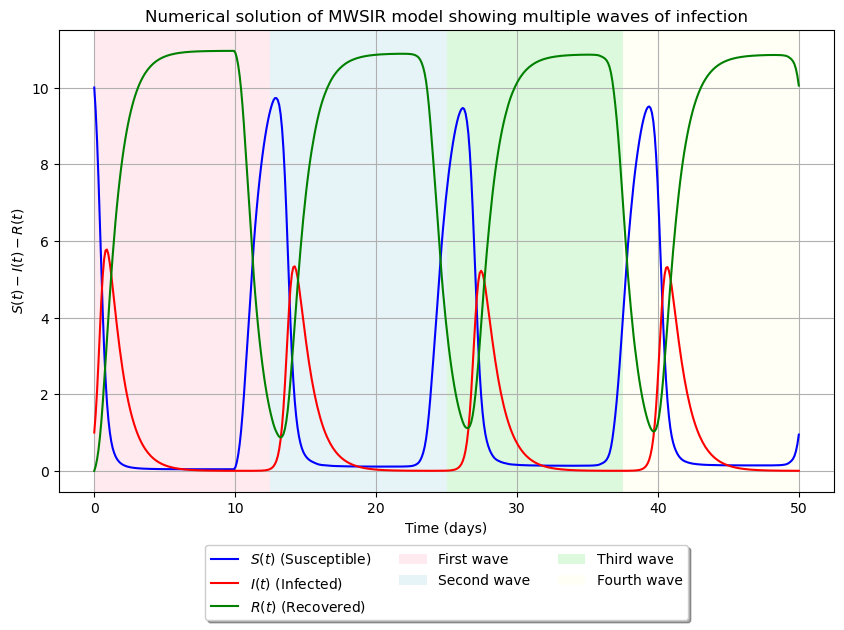

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Define parameters
mu = 0       # Birth/Death rate
alpha = 0.5  # Transmission rate per individual
beta = 1     # Recovery rate
gamma = 1    # Resusceptibility rate
tau = 10     # Time delay (in days)
N = 11       # Total population

# Initial conditions
S0 = 10      # Initial susceptible population
I0 = 1       # Initial infected population
R0 = 0       # Initial recovered population

# Time span for the solution
t_span = (0, 50)        # Simulate for 50 days
t_eval = np.linspace(*t_span, 500)  # Time points to evaluate

# Helper class to manage delayed values
class DelayedFunction:
    def __init__(self, delay):
        self.delay = delay
        self.history_t = []
        self.history_y = []
    
    def update(self, t, y):
        self.history_t.append(t)
        self.history_y.append(y)
    
    def get_delay_value(self, t):
        if t - self.delay < 0:
            return 0  # If delay is larger than t, return 0
        f = interp1d(self.history_t, self.history_y, fill_value="extrapolate")
        return f(t - self.delay)

# Initialize delayed function for I
I_delay = DelayedFunction(tau)

# Define the system of ODEs based on the new equations
def mwsir_model(t, y):
    S, I, R = y
    # Update history for delay handling
    I_delay.update(t, I)
    I_tau = I_delay.get_delay_value(t)
    
    dS_dt = mu * N - alpha * S * I + gamma * I_tau - mu * S
    dI_dt = alpha * S * I - beta * I - mu * I
    dR_dt = beta * I - gamma * I_tau - mu * R
    return [dS_dt, dI_dt, dR_dt]

# Solve the ODEs
solution = solve_ivp(mwsir_model, t_span, [S0, I0, R0], t_eval=t_eval, method='RK45')

# Extract the results
S, I, R = solution.y

# Plotting the results and marking the four waves
plt.figure(figsize=(10, 6))
plt.plot(solution.t, S, label=r'$S(t)$ (Susceptible)', color='blue')
plt.plot(solution.t, I, label=r'$I(t)$ (Infected)', color='red')
plt.plot(solution.t, R, label=r'$R(t)$ (Recovered)', color='green')

# Marking the four waves on the plot
plt.axvspan(0, 12.5, facecolor='pink', alpha=0.3, label='First wave')
plt.axvspan(12.5, 25, facecolor='lightblue', alpha=0.3, label='Second wave')
plt.axvspan(25, 37.5, facecolor='lightgreen', alpha=0.3, label='Third wave')
plt.axvspan(37.5, 50, facecolor='lightyellow', alpha=0.3, label='Fourth wave')

plt.xlabel('Time (days)')
plt.ylabel(r'$S(t)-I(t)-R(t)$')
plt.title('Numerical solution of MWSIR model showing multiple waves of infection')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3)

plt.grid()
plt.show()

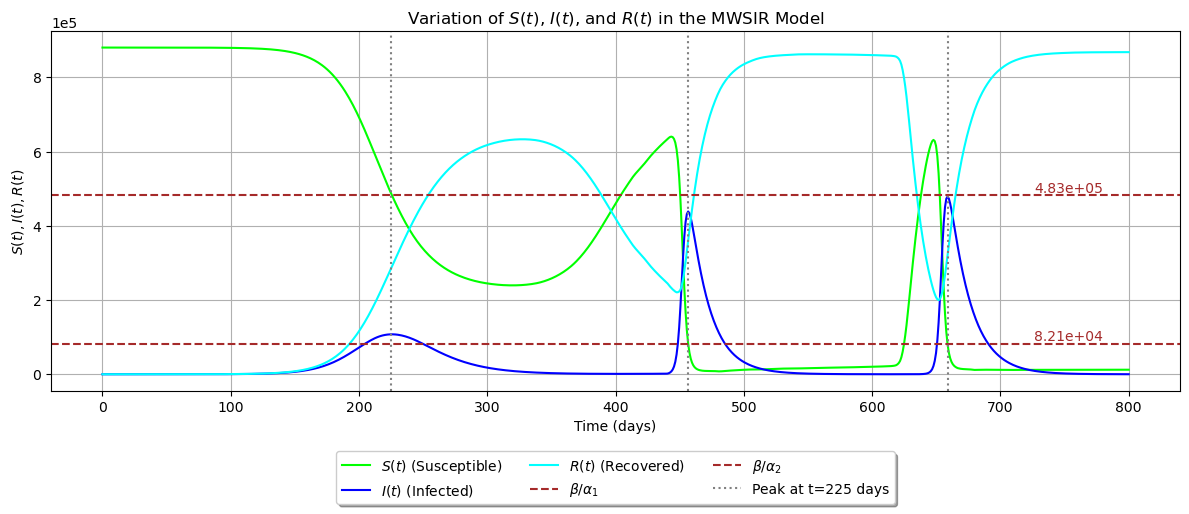

In [43]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

# Parameters
N = 8.8e5       # Total population
I0 = 1          # Initial infected
S0 = N - I0     # Initial susceptible
R0 = 0          # Initial recovered
beta = 1/14     # Recovery rate
mu = 0          # Birth/Death rate
tau1, tau2, tau3 = 173, 440, 457  # Time intervals for tau
alpha1, alpha2 = 1.48e-7, 8.7e-7  # Transmission rates
gamma1, gamma2 = 0.055, 0.08      # Resusceptibility rates

# Time span
t_span = (0, 800)         # Simulate for 800 days
t_eval = np.linspace(*t_span, 800)  # Evaluation points

# Delayed function helper
class DelayedFunction:
    def __init__(self, delay):
        self.delay = delay
        self.history_t = []
        self.history_y = []
    
    def update(self, t, y):
        self.history_t.append(t)
        self.history_y.append(y)
    
    def get_delay_value(self, t):
        if t - self.delay < 0:
            return 0  # Before delay, return 0
        f = interp1d(self.history_t, self.history_y, fill_value="extrapolate")
        return f(t - self.delay)

# Initialize delay for I
I_delay = DelayedFunction(tau1)

# Time-varying parameters
def get_alpha_gamma_tau(t):
    if t < tau1:
        return alpha1, 0, tau1
    elif tau1 <= t < tau2:
        return alpha1, gamma1, tau2
    else:
        return alpha2, gamma2, tau3

# Define MWSIR model
def mwsir_model(t, y):
    S, I, R = y
    I_delay.update(t, I)
    I_tau = I_delay.get_delay_value(t)
    
    # Obtain time-varying parameters
    alpha, gamma, tau = get_alpha_gamma_tau(t)
    
    dS_dt = -alpha * S * I + gamma * I_tau
    dI_dt = alpha * S * I - beta * I
    dR_dt = beta * I - gamma * I_tau
    return [dS_dt, dI_dt, dR_dt]

# Solve ODE
solution = solve_ivp(mwsir_model, t_span, [S0, I0, R0], t_eval=t_eval, method='RK45')

# Extract results
S, I, R = solution.y

# Calculate β/α values
beta_alpha1 = beta / alpha1
beta_alpha2 = beta / alpha2

# Find peaks in I(t)
peaks, _ = find_peaks(I, distance=150)  # Distance between peaks set to avoid close peaks

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(solution.t, S, label=r'$S(t)$ (Susceptible)', color='lime')
plt.plot(solution.t, I, label=r'$I(t)$ (Infected)', color='blue')
plt.plot(solution.t, R, label=r'$R(t)$ (Recovered)', color='cyan')

# Draw horizontal lines for β/α values and annotate them
plt.axhline(beta_alpha1, color='brown', linestyle='--', label=r'$\beta / \alpha_1$')
plt.axhline(beta_alpha2, color='brown', linestyle='--', label=r'$\beta / \alpha_2$')
plt.text(780, beta_alpha1, f'{beta_alpha1:.2e}', color='brown', ha='right', va='bottom')
plt.text(780, beta_alpha2, f'{beta_alpha2:.2e}', color='brown', ha='right', va='bottom')

# Draw vertical lines at peaks of I(t) and annotate them
for peak in peaks:
    plt.axvline(solution.t[peak], color='grey', linestyle=':', label=f'Peak at t={solution.t[peak]:.0f} days' if peak == peaks[0] else "")

# Set scientific notation on y-axis
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Labels and title
plt.xlabel('Time (days)')
plt.ylabel(r'$S(t), I(t), R(t)$')
plt.title('Variation of $S(t)$, $I(t)$, and $R(t)$ in the MWSIR Model')

# Place legend outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

# Display grid
plt.grid()
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout for legend outside the plot
plt.show()

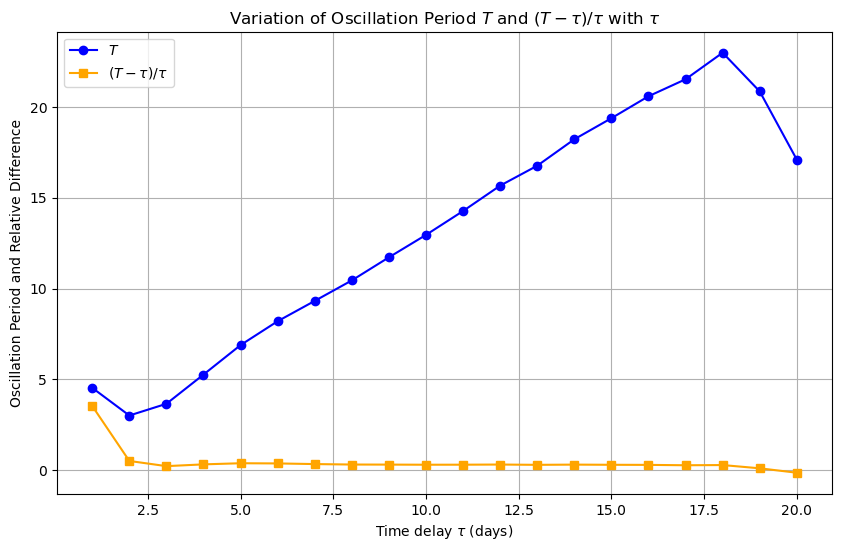

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

# Define fixed parameters
alpha = 0.5  # Transmission rate per individual
beta = 1     # Recovery rate
gamma = 1    # Resusceptibility rate
mu = 0       # Birth/Death rate
N = 11       # Total population

# Initial conditions
S0, I0, R0 = 10, 1, 0  # Initial susceptible, infected, and recovered populations
initial_conditions = [S0, I0, R0]

# Define range of tau values for the analysis
tau_values = np.linspace(1, 20, 20)  # Tau from 1 to 20 days
periods = []  # To store time period T for each tau
relative_diffs = []  # To store (T - tau) / tau for each tau

# Helper class to handle delayed values
class DelayedFunction:
    def __init__(self, delay):
        self.delay = delay
        self.history_t = []
        self.history_y = []
    
    def update(self, t, y):
        self.history_t.append(t)
        self.history_y.append(y)
    
    def get_delay_value(self, t):
        if t - self.delay < 0:
            return 0
        f = interp1d(self.history_t, self.history_y, fill_value="extrapolate")
        return f(t - self.delay)

# Solve the MWSIR model for each tau
for tau in tau_values:
    # Initialize delayed function for I
    I_delay = DelayedFunction(tau)
    
    # Define MWSIR model equations
    def mwsir_model(t, y):
        S, I, R = y
        # Update history
        I_delay.update(t, I)
        I_tau = I_delay.get_delay_value(t)
        
        dS_dt = mu * N - alpha * S * I + gamma * I_tau - mu * S
        dI_dt = alpha * S * I - beta * I - mu * I
        dR_dt = beta * I - gamma * I_tau - mu * R
        return [dS_dt, dI_dt, dR_dt]
    
    # Solve ODE system over a long time period to capture oscillations
    t_span = (0, 200)
    t_eval = np.linspace(*t_span, 2000)
    solution = solve_ivp(mwsir_model, t_span, initial_conditions, t_eval=t_eval, method='RK45')
    
    # Extract infected population and find peaks
    I = solution.y[1]
    peaks, _ = find_peaks(I, distance=20)
    
    # Calculate the time period T from peak intervals
    if len(peaks) > 1:
        T = np.mean(np.diff(solution.t[peaks]))
    else:
        T = np.nan  # If fewer than two peaks are found
    
    # Store the period and relative difference values
    periods.append(T)
    relative_diffs.append((T - tau) / tau if T else np.nan)

# Plotting Fig. 4
plt.figure(figsize=(10, 6))
plt.plot(tau_values, periods, label=r'$T$', color='blue', marker='o')
plt.plot(tau_values, relative_diffs, label=r'$(T - \tau) / \tau$', color='orange', marker='s')

# Label the axes
plt.xlabel(r'Time delay $\tau$ (days)')
plt.ylabel('Oscillation Period and Relative Difference')
plt.title(r'Variation of Oscillation Period $T$ and $(T - \tau) / \tau$ with $\tau$')

# Show legend and grid
plt.legend()
plt.grid()
plt.show()

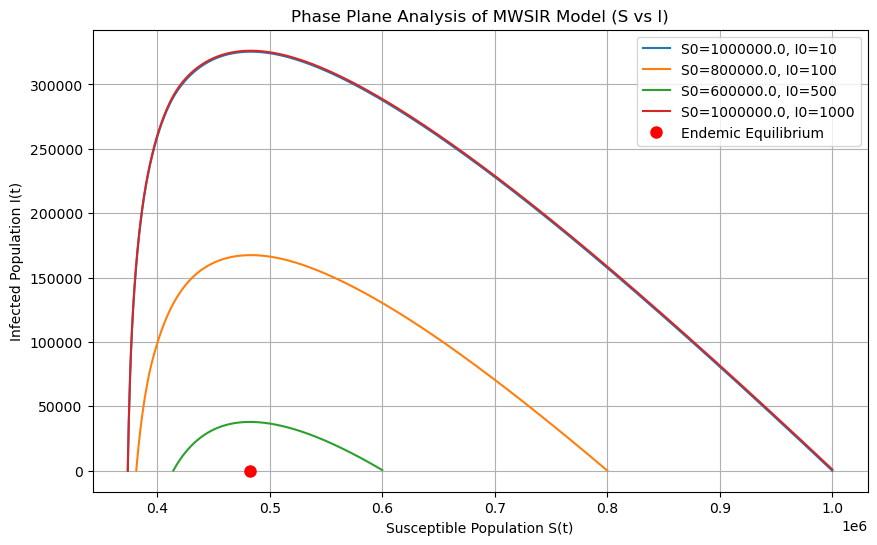

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Model parameters
alpha = 1.48e-7  # transmission rate for initial phase
beta = 1/14      # recovery rate
mu = 0           # natural birth and death rate (assumed 0 for simplicity in phase analysis)
gamma = 0.055    # reinfection rate
tau = 173        # time delay, initial phase

# Define system of differential equations for S and I in the absence of R (for phase plane)
def mwsir_phase(t, y, alpha, beta, mu, gamma, tau):
    S, I = y
    # S and I differential equations without delay
    dS_dt = mu - alpha * S * I + gamma * I - mu * S
    dI_dt = alpha * S * I - (beta + mu) * I
    return [dS_dt, dI_dt]

# Set up initial conditions and time range
t_span = (0, 1000)  # Time span for the simulation
initial_conditions = [
    (1e6, 10), (8e5, 100), (6e5, 500), (1e6, 1000)  # Different starting points for S and I
]
t_eval = np.linspace(*t_span, 10000)  # Time points to evaluate

# Plot the phase plane trajectories
plt.figure(figsize=(10, 6))
for S0, I0 in initial_conditions:
    sol = solve_ivp(mwsir_phase, t_span, [S0, I0], args=(alpha, beta, mu, gamma, tau), t_eval=t_eval)
    plt.plot(sol.y[0], sol.y[1], label=f'S0={S0}, I0={I0}')

# Plot endemic equilibrium (S*, I*) point for reference
S_star = beta / alpha  # Theoretical endemic equilibrium for S
I_star = (mu / (beta + mu)) * (1 - S_star / (beta + mu))  # Derived endemic I equilibrium point
plt.plot(S_star, I_star, 'ro', label="Endemic Equilibrium", markersize=8)

# Set up the plot labels and legend
plt.xlabel('Susceptible Population S(t)')
plt.ylabel('Infected Population I(t)')
plt.title('Phase Plane Analysis of MWSIR Model (S vs I)')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
from sympy import symbols, Function, Eq, dsolve

# Define the symbols
a, b, t = symbols('a b t')

# Define the functions
S = Function('S')(t)
I = Function('I')(t)
R = Function('R')(t)

# Define the system of differential equations
eq1 = Eq(S.diff(t), -a * S * I)
eq2 = Eq(I.diff(t), a * S * I - b * I)
eq3 = Eq(R.diff(t), b * I)

# Solve the system of differential equations
solution_S = dsolve(eq1)
solution_I = dsolve(eq2)
solution_R = dsolve(eq3)

# Display the solutions
print(solution_S)
print(solution_I)
print(solution_R)

Eq(S(t), C1*exp(-a*Integral(I(t), t)))
Eq(I(t), C1*exp(a*Integral(S(t), t) - b*t))
Eq(R(t), C1 + b*Integral(I(t), t))


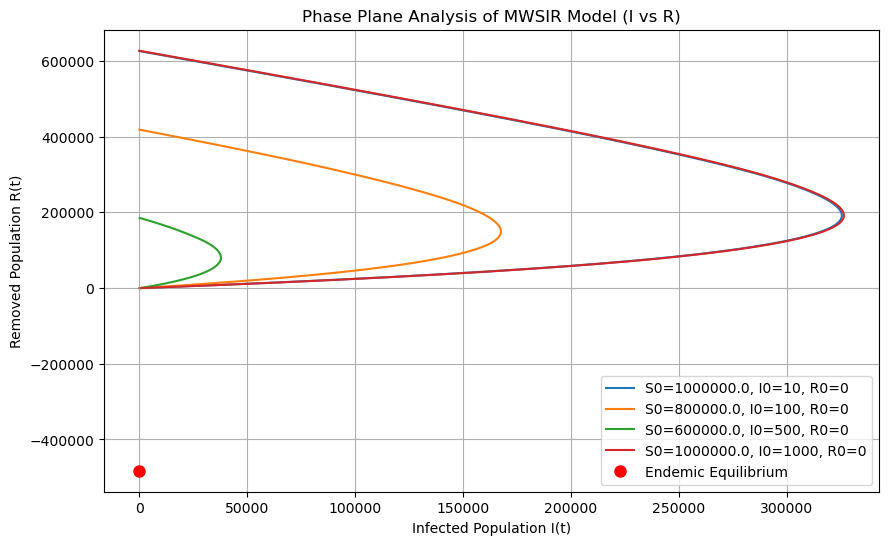

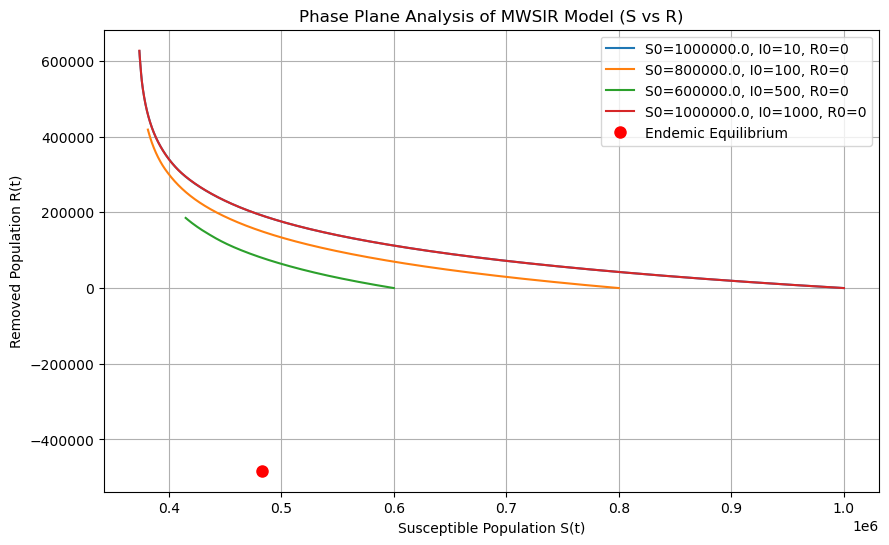

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Model parameters
alpha = 1.48e-7  # transmission rate for initial phase
beta = 1/14      # recovery rate
mu = 0           # natural birth and death rate (assumed 0 for simplicity in phase analysis)
gamma = 0.055    # reinfection rate
tau = 173        # time delay, initial phase

# Define full MWSIR model including R for phase plane analysis
def mwsir_full(t, y, alpha, beta, mu, gamma, tau):
    S, I, R = y
    dS_dt = mu - alpha * S * I + gamma * I - mu * S
    dI_dt = alpha * S * I - (beta + mu) * I
    dR_dt = beta * I - gamma * I - mu * R
    return [dS_dt, dI_dt, dR_dt]

# Set up initial conditions and time range
t_span = (0, 1000)  # Time span for the simulation
initial_conditions_full = [
    (1e6, 10, 0), (8e5, 100, 0), (6e5, 500, 0), (1e6, 1000, 0)  # Starting points for S, I, R
]
t_eval = np.linspace(*t_span, 10000)  # Time points to evaluate

# Calculate theoretical equilibrium points
S_star = beta / alpha  # Theoretical endemic equilibrium for S
I_star = (mu / (beta + mu)) * (1 - S_star / (beta + mu))  # Endemic equilibrium for I
R_star = 1 - S_star - I_star  # Simplified calculation for R in an isolated system

# Plot phase plane trajectories for I vs R including equilibrium point
plt.figure(figsize=(10, 6))
for S0, I0, R0 in initial_conditions_full:
    sol = solve_ivp(mwsir_full, t_span, [S0, I0, R0], args=(alpha, beta, mu, gamma, tau), t_eval=t_eval)
    plt.plot(sol.y[1], sol.y[2], label=f'S0={S0}, I0={I0}, R0={R0}')

# Plot endemic equilibrium point on I vs R
plt.plot(I_star, R_star, 'ro', label="Endemic Equilibrium", markersize=8)
plt.xlabel('Infected Population I(t)')
plt.ylabel('Removed Population R(t)')
plt.title('Phase Plane Analysis of MWSIR Model (I vs R)')
plt.legend()
plt.grid(True)
plt.show()

# Plot phase plane trajectories for S vs R including equilibrium point
plt.figure(figsize=(10, 6))
for S0, I0, R0 in initial_conditions_full:
    sol = solve_ivp(mwsir_full, t_span, [S0, I0, R0], args=(alpha, beta, mu, gamma, tau), t_eval=t_eval)
    plt.plot(sol.y[0], sol.y[2], label=f'S0={S0}, I0={I0}, R0={R0}')

# Plot endemic equilibrium point on S vs R
plt.plot(S_star, R_star, 'ro', label="Endemic Equilibrium", markersize=8)
plt.xlabel('Susceptible Population S(t)')
plt.ylabel('Removed Population R(t)')
plt.title('Phase Plane Analysis of MWSIR Model (S vs R)')
plt.legend()
plt.grid(True)
plt.show()